In [1]:
%pylab inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision import datasets
from torchvision.transforms import ToTensor, Grayscale

# from tqdm import trange, tqdm
from functools import partial
from tqdm import tqdm, trange
tqdm = partial(tqdm, position=0, leave=True)


Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
BATCH=1

In [4]:
train_data = datasets.MNIST(
	root='data',
	train=True,
	transform=transforms.Compose([
		ToTensor(),
		# Grayscale(1),
		# transforms.Normalize((0.1307,), (0.3081,)),
	]),
	download=True,
);

trainloader = torch.utils.data.DataLoader(
	train_data,
	batch_size=BATCH,
	num_workers=12,
	shuffle=True
)
print(len(trainloader))

60000


torch.Size([1, 1, 28, 28])


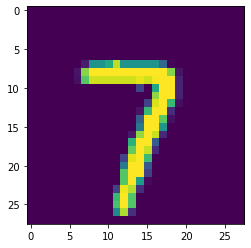

In [5]:
for i, data in enumerate(trainloader):
	if i == 10:
		print(data[0].shape)
		imshow(data[0].reshape(28,28).numpy())
		break

In [6]:
class G(nn.Module):
	def __init__(self):
		super(G, self).__init__()

		self.deconvs = nn.Sequential(
			nn.ConvTranspose2d(1, 24, 3),
			nn.ReLU(inplace=True),

			nn.ConvTranspose2d(24, 32, 3),
			nn.ReLU(inplace=True),

			nn.ConvTranspose2d(32, 40, 3),
			nn.ReLU(inplace=True),

			nn.ConvTranspose2d(40, 1, 3),
		)

	def forward(self, x):
		x = self.deconvs(x)

		return x

noise shape: torch.Size([1, 1, 20, 20])
out shape: torch.Size([1, 1, 28, 28])
out 0 shape: torch.Size([1, 28, 28])


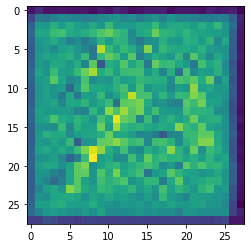

In [7]:
t_generator = G().cuda()

t_noise = torch.randn(BATCH, 1, 20, 20).cuda()
print('noise shape:', t_noise.shape)

t_out = t_generator(t_noise)

print('out shape:', t_out.shape)
print('out 0 shape:', t_out[0].shape)

imshow(t_out[0].reshape(28, 28).cpu().detach())

In [8]:
class D(nn.Module):
	def __init__(self):
		super(D, self).__init__()

		self.convs = nn.Sequential(
			nn.Conv2d(1, 16, 3),
			nn.BatchNorm2d(16),
			nn.LeakyReLU(inplace=True),

			nn.Conv2d(16, 32, 3),
			nn.BatchNorm2d(32),
			nn.LeakyReLU(inplace=True),

			nn.Conv2d(32, 64, 3),
			nn.BatchNorm2d(64),
			nn.Sigmoid(),
		)

		self.classifier = nn.Linear(64 * 22 * 22, 1)

	def forward(self, x):
		x = self.convs(x)

		x = x.reshape(x.shape[0], -1)

		x = self.classifier(x)

		return x

In [9]:
generator = G().cuda()
discriminator = D().cuda()

In [10]:
# loss_fn = nn.BCEWithLogitsLoss().cuda()
loss_fn = nn.BCEWithLogitsLoss().cuda()

g_optim = optim.Adam(generator.parameters(), lr=0.001) # 3e-4
d_optim = optim.Adam(discriminator.parameters(), lr=0.001)

EPOCHS = 10

losses = []
em_losses = []

In [11]:
def test_render(g):
  n1 = torch.randn(BATCH, 1, 20, 20).cuda()
  out = g(n1)
  imshow(out[0].reshape(28, 28).cpu().detach())

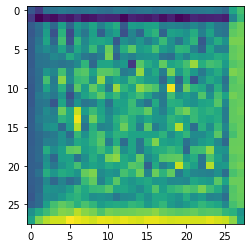

In [12]:
test_render(generator)

In [ ]:
for epoch in trange(EPOCHS):
	for i, data in tqdm(enumerate(trainloader)):
		# if i > 5000: break

		images = data[0].cuda()

		# train discriminator
		d_out_real = discriminator(images)
		d_optim.zero_grad()
		d_loss_real = loss_fn(d_out_real, torch.ones(BATCH, 1).cuda())
		d_loss_real.backward()
		d_optim.step()

		noise1 = torch.randn(BATCH, 1, 20, 20).cuda()
		g_out_fake = generator(noise1)
		d_out_fake = discriminator(g_out_fake)
		d_optim.zero_grad()
		d_loss_fake = loss_fn(d_out_fake, torch.ones(BATCH, 1).cuda())
		d_loss_fake.backward()
		d_optim.step()
		
		# train generator
		noise2 = torch.randn(BATCH, 1, 20, 20).cuda()
		g_out = generator(noise2)
		d_out = discriminator(g_out)
		g_optim.zero_grad()
		t_loss = loss_fn(d_out, torch.ones(BATCH, 1).cuda())
		t_loss.backward()
		g_optim.step()

	test_render(generator)


29861it [06:22, 78.40it/s]

In [ ]:
n1 = torch.randn(BATCH, 1, 20, 20).cuda()
out = generator(n1)
imshow(out[0].reshape(28, 28).cpu().detach())